In [1]:
import scanpy as sc
import os,sys,glob
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
sc.settings.n_jobs = 40
sc.set_figure_params(figsize=(4,4), vector_friendly = True)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 100

## Run PCA

In [ ]:
# adata = sc.read_h5ad("Data/Output_231215_adata_scvi_random_sampleID.h5ad")

In [ ]:
# sc.pp.highly_variable_genes(
#     adata, n_top_genes=5000, flavor="cell_ranger", batch_key="sampleID"
# ) # 2m

In [ ]:
# sc.tl.pca(adata, n_comps=50, use_highly_variable=True) # 10m

In [ ]:
# adata.write_h5ad("Data/Output_231215_adata_scvi_random_sampleID_SEACells.h5ad")

## Start SEACells

In [2]:
import SEACells
import math

In [3]:
adata = sc.read_h5ad("Data/Output_231215_adata_scvi_random_sampleID_SEACells.h5ad")

In [4]:
adata_sub = adata[adata.obs["Leiden"] == "C0"].copy()

In [13]:
## Core parameters 
n_SEACells = math.floor(adata_sub.n_obs/75) # 393060/75 = 5240.9333333
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data
## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [14]:
model = SEACells.core.SEACells(adata_sub, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5,
                  use_sparse=True)

Welcome to SEACells!


In [15]:
model.construct_kernel_matrix()
M = model.kernel_matrix # 5m

Computing kNN graph using scanpy NN ...


/home/ssun1116/anaconda3/envs/seacells/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Computing radius for adaptive bandwidth kernel...


  0%|          | 0/52564 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/52564 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/52564 [00:00<?, ?it/s]

Constructing CSR matrix...


In [16]:
# Initialize archetypes
model.initialize_archetypes() # 36s

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 682 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]

Selecting 18 cells from greedy initialization.


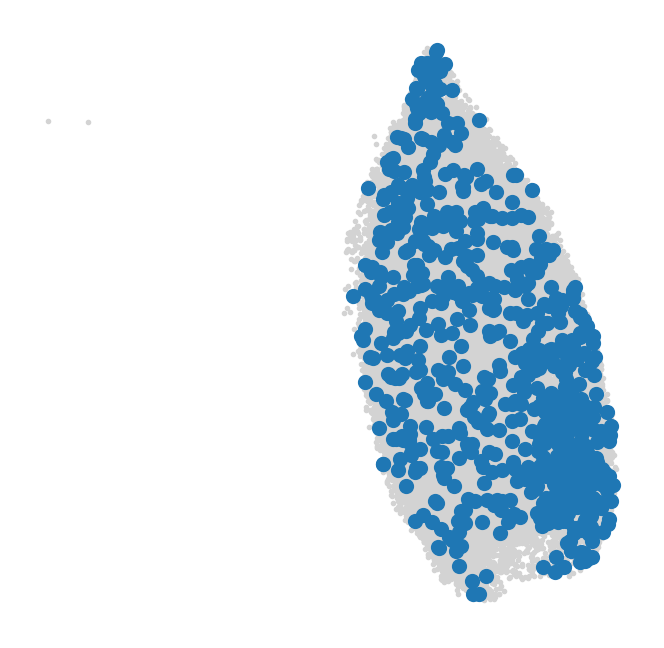

In [23]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata_sub, model, save_as = "Figures/SEACells_plot_initialization_Cluster_C0.pdf")

In [24]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00429
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 44 iterations.


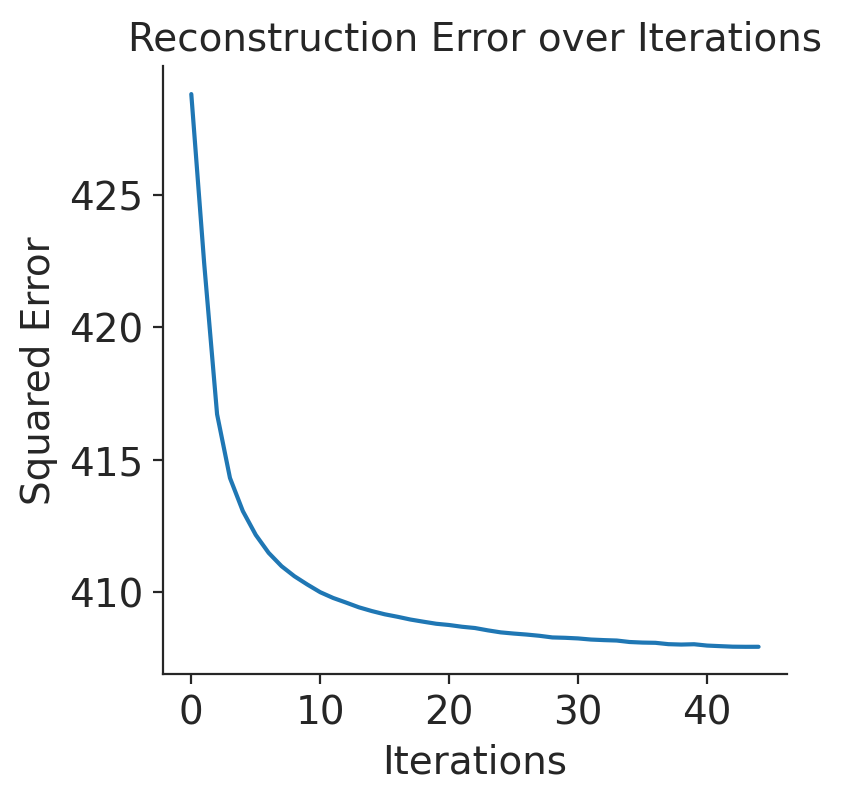

In [25]:
# Check for convergence 
model.plot_convergence()

## Summarizing data

In [26]:
SEACell_ad = SEACells.core.summarize_by_SEACell(adata_sub, SEACells_label='SEACell', summarize_layer='counts')
SEACell_ad

100%|██████████| 700/700 [00:10<00:00, 66.02it/s]
/home/ssun1116/anaconda3/envs/seacells/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 700 × 49133
    layers: 'raw'

/home/ssun1116/anaconda3/envs/seacells/lib/python3.10/site-packages/SEACells-0.3.3-py3.10.egg/SEACells/plot.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mcs = umap.groupby("SEACell").mean().reset_index()
/home/ssun1116/anaconda3/envs/seacells/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/ssun1116/anaconda3/envs/seacells/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


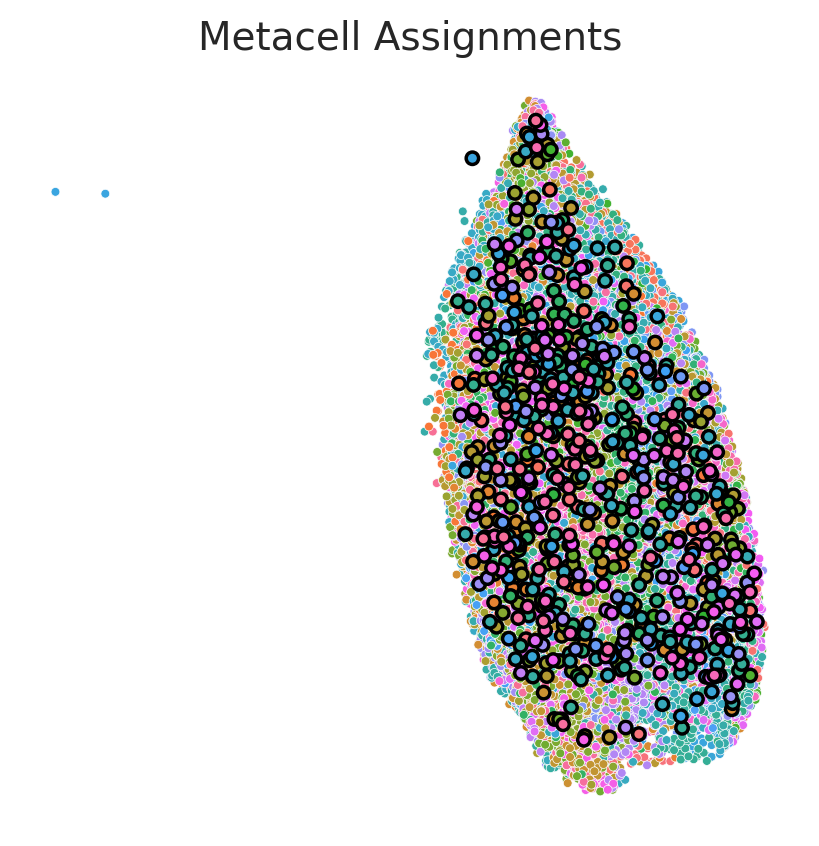

: 

In [33]:
SEACells.plot.plot_2D(adata_sub, key='X_umap', colour_metacells=True)

In [32]:
adata_sub.obs["SEACell"]

index
10X185_8:ACCCTTGCAGACACCC              SEACell-286
AAACCCACAGTGAGCA-LKTX_190129_01_A01    SEACell-217
AAAGGTATCGGCTGGT-LKTX_190129_01_A01    SEACell-565
AATCACGAGAGTCCGA-LKTX_190129_01_A01    SEACell-262
AATCGACGTGAGCCAA-LKTX_190129_01_A01    SEACell-520
                                          ...     
hsDG99HC_TTTGGTTTCGGTATGT-1            SEACell-208
hsDG99HC_TTTGTTGCAGACGATG-1            SEACell-241
hsDG99HC_TTTGTTGCATAGCTGT-1            SEACell-267
hsDG99HC_TTTGTTGTCATCTATC-1            SEACell-495
hsDG99HC_TTTGTTGTCGTTAGAC-1            SEACell-679
Name: SEACell, Length: 52564, dtype: object